## Linear Regration using Multi Layer Perceptron

In [11]:
# Step 0 - LIBRARY INSTALLATION
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import tqdm

print("All libraries loaded successfully!")

All libraries loaded successfully!


In [12]:
house_data = pd.read_csv('./house-prices.csv')
house_data.head()

house_num = house_data.iloc[0, 0]
house_price = house_data.iloc[0, 0:]

print('House Number: {}'.format(house_num))
print('House Price: {}'.format(house_price['Price']))
print('House Data Shape: {}'.format(house_data.shape))

House Number: 1
House Price: 114300
House Data Shape: (128, 8)


In [13]:
# STEP 1: DATASET CLASS DEFINITION

class HousePricesDataset(Dataset):

    def __init__(self, csv_file):

        print(f"Loading dataset from: {csv_file}")
        self.data = pd.read_csv(csv_file)
        print(f"Dataset loaded with {len(self.data)} houses")

    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx):

        # Get the house data at index idx
        house = self.data.iloc[idx]

        # Extract input features and convert to PyTorch tensor
        features = torch.tensor([
            house['SqFt'],
            house['Bedrooms'],
            house['Bathrooms'],
            house['Offers']
        ], dtype=torch.float32)

        # Extract target (price) and convert to PyTorch tensor
        target = torch.tensor(house['Price'], dtype=torch.float32)

        return features, target

In [14]:
# STEP 2: CREATE DATASET AND DATALOADERS

# Create the full dataset
dataset = HousePricesDataset('./house-prices.csv')

# Split dataset into training (70%) and testing (30%)
train_dataset, test_dataset = random_split(dataset, [0.7, 0.3])

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Create DataLoaders for efficient batch processing
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

# Let's examine a batch of training data
print("\n--- Examining Training Data ---")
for features, targets in train_loader:
    print(f"Features batch shape: {features.shape}")  # Should be [4, 4] - 4 samples, 4 features each
    print(f"Targets batch shape: {targets.shape}")    # Should be [4] - 4 price values
    print(f"Sample features: {features[0]}")          # First house features
    print(f"Sample target: {targets[0]}")             # First house price
    break  # Just show first batch

Loading dataset from: ./house-prices.csv
Dataset loaded with 128 houses
Training samples: 90
Testing samples: 38

--- Examining Training Data ---
Features batch shape: torch.Size([4, 4])
Targets batch shape: torch.Size([4])
Sample features: tensor([2.1100e+03, 3.0000e+00, 2.0000e+00, 2.0000e+00])
Sample target: 142600.0


In [15]:
# STEP 3: MODEL DEFINITION

class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(4, 16),
        nn.ReLU(),
        nn.Linear(16, 4),
        nn.ReLU(),
        nn.Linear(4, 1)
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)  # Apply linear transformation: Wx + b
        return output.squeeze()  # Remove extra dimension to match target shape

# Create model instance
model = NeuralNetwork()
print(f"\n--- Model Architecture ---")
print(model)

# Show initial model parameters (weights and bias)
print("\n--- Initial Model Parameters ---")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")


--- Model Architecture ---
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)

--- Initial Model Parameters ---
linear_relu_stack.0.weight: tensor([[ 0.4329,  0.4136,  0.0955,  0.0812],
        [-0.4477,  0.3951, -0.0756,  0.3964],
        [-0.1912,  0.1146,  0.2929,  0.0188],
        [ 0.0688,  0.4289,  0.0844,  0.0661],
        [ 0.2899, -0.0401, -0.0856, -0.0440],
        [-0.3615,  0.3932, -0.0431, -0.1177],
        [-0.4622,  0.0842,  0.3133, -0.1611],
        [ 0.1807, -0.1566, -0.1215,  0.1413],
        [-0.0363, -0.1157, -0.1940,  0.2279],
        [-0.0231, -0.4709,  0.3692, -0.0363],
        [ 0.1981, -0.0809,  0.4192, -0.4590],
        [ 0.3139,  0.1622,  0.2819, -0.1332],
        [ 0.4213, -0.2857, -0.3714,  0.3259],
        [-0.4700,  0.3304,  0.4550,  0.2018],
  

In [16]:
# STEP 4: LOSS FUNCTION AND OPTIMIZER

# Loss function: Mean Squared Error (same as our manual MSE function)
loss_fn = nn.MSELoss()

# Optimizer: Stochastic Gradient Descent (similar to manual gradient update)
learning_rate = 0.001

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print(f"\nUsing learning rate: {learning_rate}")


Using learning rate: 0.001


In [17]:
# STEP 5: TRAINING LOOP

epochs = 1000  # Make sure this matches your intended number
train_losses = []
test_rmse_history = []

print(f"\n--- Starting Training for {epochs} epochs ---")

for epoch in range(epochs):
    # TRAINING PHASE
    model.train()
    epoch_losses = []

    for batch_features, batch_targets in train_loader:
        # Forward pass
        predictions = model(batch_features)
        loss = loss_fn(predictions, batch_targets)
        epoch_losses.append(loss.item())

        # Backward pass
        optimizer.zero_grad()        # Clear previous gradients
        loss.backward()              # Compute gradients
        optimizer.step()             # Update weights

    # Store average training loss for this epoch
    avg_train_loss = np.mean(epoch_losses)
    train_losses.append(avg_train_loss)

    # Evaluation Phase
    model.eval()
    test_rmse_values = []  # Collect all test batch RMSEs for this epoch

    with torch.no_grad():
        for test_features, test_targets in test_loader:
            test_predictions = model(test_features)
            test_mse = loss_fn(test_predictions, test_targets).item()
            test_rmse = np.sqrt(test_mse)
            test_rmse_values.append(test_rmse)

    # Store the average RMSE for this epoch (though usually test_loader has only 1 batch)
    epoch_test_rmse = np.mean(test_rmse_values)
    test_rmse_history.append(epoch_test_rmse)  # Only append ONCE per epoch

    # Print progress
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test RMSE: {epoch_test_rmse:.4f}')


--- Starting Training for 1000 epochs ---
Epoch [20/1000], Train Loss: 17578863455082131418723123200.0000, Test RMSE: 129415209940288.8281
Epoch [40/1000], Train Loss: 2786690122831114233995853824.0000, Test RMSE: 51526924384656.7656
Epoch [60/1000], Train Loss: 441761318160399474691670016.0000, Test RMSE: 20515578362945.8828
Epoch [80/1000], Train Loss: 70030246536697227971133440.0000, Test RMSE: 8168320406476.8301
Epoch [100/1000], Train Loss: 11101566484050670438580224.0000, Test RMSE: 3252236189738.3398
Epoch [120/1000], Train Loss: 1759881053400632240635904.0000, Test RMSE: 1294886230294.9663
Epoch [140/1000], Train Loss: 278985558365048796086272.0000, Test RMSE: 515561851444.0302
Epoch [160/1000], Train Loss: 44226322488958539268096.0000, Test RMSE: 205272303161.4157
Epoch [180/1000], Train Loss: 7010980212950199959552.0000, Test RMSE: 81729570524.1497
Epoch [200/1000], Train Loss: 1111415856216854888448.0000, Test RMSE: 32540801799.6169
Epoch [220/1000], Train Loss: 17618697698


--- Training Complete ---
Final Training Loss: 641421529.7391
Final Test RMSE: 27782.2699

--- Final Model Parameters ---
linear_relu_stack.0.weight: tensor([[-2.5550e+04, -3.9839e+01, -3.1576e+01, -3.2730e+01],
        [-4.4771e-01,  3.9510e-01, -7.5589e-02,  3.9635e-01],
        [-1.9124e-01,  1.1461e-01,  2.9292e-01,  1.8804e-02],
        [-9.9532e+25, -1.6091e+23, -1.3323e+23, -1.1562e+23],
        [-3.0540e+04, -4.8155e+01, -3.7943e+01, -3.9263e+01],
        [-3.6151e-01,  3.9316e-01, -4.3076e-02, -1.1770e-01],
        [-4.6215e-01,  8.4222e-02,  3.1331e-01, -1.6109e-01],
        [-5.0200e+04, -7.9243e+01, -6.2349e+01, -6.4324e+01],
        [-3.6343e-02, -1.1565e-01, -1.9404e-01,  2.2793e-01],
        [-2.3139e-02, -4.7087e-01,  3.6924e-01, -3.6276e-02],
        [-2.8291e+26, -4.5739e+23, -3.7871e+23, -3.2864e+23],
        [-4.4976e+26, -7.2714e+23, -6.0205e+23, -5.2245e+23],
        [-2.4677e+04, -3.9163e+01, -3.0961e+01, -3.1364e+01],
        [-4.6998e-01,  3.3042e-01,  4.5497e

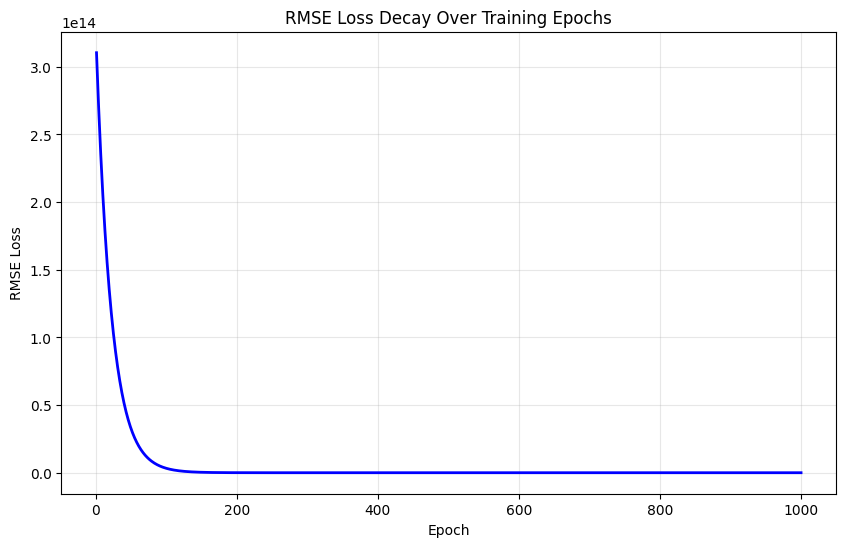

In [18]:
# STEP 6: RESULTS AND VISUALIZATION

print(f"\n--- Training Complete ---")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test RMSE: {test_rmse_history[-1]:.4f}")

# Show final model parameters
print("\n--- Final Model Parameters ---")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

# Plot RMSE loss decay
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), test_rmse_history, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.title('RMSE Loss Decay Over Training Epochs')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# STEP 7: MAKE PREDICTIONS ON TEST SET

print("\n--- Sample Predictions vs Actual ---")
model.eval()
with torch.no_grad():
    for test_features, test_targets in test_loader:
        predictions = model(test_features)
        # Show first 5 predictions vs actual
        for i in range(min(5, len(predictions))):
            print(f"House {i+1}: Predicted=${predictions[i]:.2f}, Actual=${test_targets[i]:.2f}")
        break


--- Sample Predictions vs Actual ---
House 1: Predicted=$128585.50, Actual=$199500.00
House 2: Predicted=$128585.50, Actual=$109700.00
House 3: Predicted=$128585.50, Actual=$182000.00
House 4: Predicted=$128585.50, Actual=$108200.00


## Convolutional Neural Network

In [51]:
import matplotlib.pyplot as plt

In [52]:
dataset = datasets.OxfordIIITPet(root='./', split='trainval', download=True)

In [25]:
dataset.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

## HuggingFace Load Dataset

In [26]:
# Loading the 'dataset' library to load the data from Hugging Face

!pip install datasets

In [27]:
from datasets import load_dataset

# Load the IMDB dataset
dataset = load_dataset('imdb')
dataset.save_to_disk('Data_HF/imdb')

# Print the first example
sample = dataset['train'][0]
text, label = sample['text'], sample['label']

# Display the text and corresponding label
print("Sample Text:", text)
print("Label:", "Positive" if label == 1 else "Negative")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Sample Text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far

## Kaggle Flower Recognition
Download and load the dataset to any directory and connect that.
https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

In [33]:
!pip install kagglehub

In [34]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flowers-recognition' dataset.
Path to dataset files: /kaggle/input/flowers-recognition


In [35]:
# If you want to upload the data to Google Drive and mount the drive to Google Colab
# """
# from google.colab import drive
# drive.mount('/content/drive')
# """

In [59]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet mean and std
])

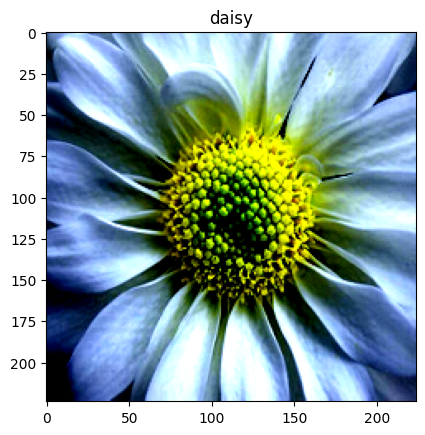

In [60]:
# Load the dataset using ImageFolder
dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/flowers-recognition/flowers', transform=transform)
img, label = dataset[0]

img_RGB = img.permute(1, 2, 0)
plt.imshow(img_RGB), plt.title(dataset.classes[label]), plt.show();

In [61]:
# Split dataset into training and validation sets
train_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(f'Train set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Display a few sample images with their labels
classes = dataset.classes  # List of class names
print(classes)

Train set size: 431, Validation set size: 3886
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


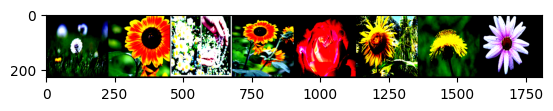

dandelion sunflower daisy sunflower rose sunflower dandelion daisy


In [62]:
# Function to show an image
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))

In [64]:
import torch.nn as nn
import torch.optim as optim

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)     # Flatten the tensor
        x = self.classifier(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN(num_classes=len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(2):  # 10 epochs
    running_loss = 0.0
    for images, labels in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

print('Finished Training')

100%|██████████| 14/14 [03:18<00:00, 14.16s/it]


Epoch 1, Loss: 13.917509172643934


100%|██████████| 14/14 [02:51<00:00, 12.28s/it]

Epoch 2, Loss: 1.4230463675090246
Finished Training


In [66]:
# Evaluate the model on the validation set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm.tqdm(val_loader):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print(f'Accuracy on validation set: {100 * correct / total:.2f}%')

100%|██████████| 122/122 [07:59<00:00,  3.93s/it]

Accuracy on validation set: 37.42%
